# Lithology prediction by core images

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import pickle
import collections
import matplotlib.pyplot as plt
import torch
import time

sys.path.insert(0, os.path.join("..", "..", ".."))

from petroflow import Well, WellBatch, WS, WellDataset
from petroflow.batchflow.models.metrics import SegmentationMetricsByPixels
from petroflow.batchflow.models.torch import UNet, ResNet18, ResNet34
from petroflow.batchflow import Dataset, FilesIndex, Pipeline, V, B, inbatch_parallel, I, W, F

# from utils import *

## Dataset

In [2]:
index = FilesIndex(path='/notebooks/data/august_dataset/core_photo_resize/*/*', dirs=True)
class MyWellBatch(WellBatch):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, resize=False, **kwargs)

ds = Dataset(index=index, batch_class=MyWellBatch)
ds.split(0.8, shuffle=42)

## Compute statistics to transform lithology to labels

In [35]:
class LithologyUtils:
    @staticmethod
    def process_lithology(lithology):
        def _process_item(item):
            _lithology = item.split()
            if _lithology[0] == 'Переслаивание':
                return item
            elif len(_lithology) > 1 and _lithology[1] == 'порода':
                return item
            else:
                return _lithology[0]
        return [df.apply(_process_item) for df in lithology]
    
    @staticmethod
    def rename_lithology(lithology, types, default='другое'):
        res = []
        for df in lithology:
            start = time.time()
            df[~df.isin(types)] = default
            res.append(df)
            print((time.time()-start))
        return res

    @staticmethod
    def get_labels_mapping(array, threshold=None, leave=None, counter=None):
        if threshold is not None:
            name_mapping = {item: item if counter[item] > threshold else 'другое' for item in counter}
        else:
            name_mapping = {item: item for item in array}
        if leave is not None:
            name_mapping = {k: v if k in leave else 'другое' for k, v in name_mapping.items()}
        label_mapping = {item: i for i, item in enumerate(np.unique(list(name_mapping.values())))}
        return {item: label_mapping[name_mapping[item]] for item in name_mapping}, name_mapping
    
    @staticmethod
    def get_loss_weights(counter, labels_mapping):
        weights = np.zeros(len(set(labels_mapping.values())))
        for key, value in counter.items():
            weights[labels_mapping[key]] += value
        weights = 1 / weights
        return weights / sum(weights)
    
    @staticmethod
    def drop_lithology(lithology, types):
        def _filter_item(item):
            return item in types
        print([len(df) for df in lithology])
        res = [df[df.FORMATION.apply(_filter_item)] for df in lithology]  
        default = pd.DataFrame({'DEPTH_FROM': [], 'DEPTH_TO': [], 'FORMATION': []}).set_index(['DEPTH_FROM', 'DEPTH_TO'])
        res = [df if len(df) > 0 else default for df in res]
        return res

In [36]:
ppl_template = (Pipeline()
    .add_namespace(LithologyUtils)
    .init_variable('lithology', default=[])
#     .rename_lithology(
#         WS('core_lithology').FORMATION.ravel(),
#         types=['Алевролит', 'Аргиллит', 'Песчаник', 'Уголь'],
#         save_to=WS('core_lithology').FORMATION
#     )
    .update(V('lithology', mode='e'), WS('core_lithology').FORMATION.values.ravel())
)

In [37]:
(ppl_template
    .after
    .init_variable('counter')
    .init_variable('mapping')
    .add_namespace(np, collections, LithologyUtils)
    .concatenate(V('lithology'), save_to=V('lithology'))
    .Counter(V('lithology'), save_to=V('counter'))
    .get_labels_mapping(V('lithology'), leave=['Алевролит', 'Аргиллит', 'Песчаник', 'Уголь'], save_to=V('mapping'))
)

In [38]:
# ppl = ppl_template << ds
# ppl.run(1, n_epochs=1, bar=True)

# with open('mapping.pkl', 'wb') as f:
#     pickle.dump(ppl.v('mapping'), f)

# with open('counter.pkl', 'wb') as f:
#     pickle.dump(ppl.v('counter'), f)

# labels_mapping, name_mapping = ppl.v('mapping')

with open('mapping.pkl', 'rb') as f:
    mapping = pickle.load(f)
    
with open('counter.pkl', 'rb') as f:
    counter = pickle.load(f)

labels_mapping, name_mapping = mapping
reverse_mapping = {value: name_mapping[key] for key, value in labels_mapping.items()}

weights = LithologyUtils.get_loss_weights(counter, labels_mapping)

counter

Counter({'Алевролит': 837,
         'Алевролит глинистый': 744,
         'Алевролит глинистый известковый': 9,
         'Алевролит песчанистый': 1466,
         'Ангидрит': 2,
         'Ангидрит-доломитовая порода': 26,
         'Аргиллит': 290,
         'Аргиллит алевритовый или алевритистый': 1387,
         'Аргиллит битуминозный': 19,
         'Аргиллит известковистый или известковый': 11,
         'Аргиллит сидеритизированный': 10,
         'Аргиллит углистый': 175,
         'Боксит': 2,
         'Брекчия': 3,
         'Брекчия известковистая': 1,
         'Галит': 6,
         'Глина': 126,
         'Глинисто-карбонатная порода': 61,
         'Глинисто-кремнистая порода': 7,
         'Гравелит': 12,
         'Гранит': 3,
         'Гранитогнейс': 2,
         'Доломит': 137,
         'Доломит ангидритизированный': 5,
         'Доломит битуминозный': 17,
         'Доломит глинистый': 65,
         'Доломит известковистый или известковый': 41,
         'Доломит трещиноватый': 33,
       

## Define train pipeline

In [39]:
# import time

# N_CLASSES = len(set(labels_mapping.values()))
# BATCH_SIZE = 1
# N_EPOCH = 1
# LENGTH = 0.1
# SHAPE = (6, int(500 * LENGTH), 50)

# model_config = {'initial_block/inputs': 'images',
#                 'inputs/images/shape': SHAPE,
#                 'inputs/labels/classes': len(np.unique(list(labels_mapping.values()))),
#                 'head/kernel_size': (1, 50),
#                 'head/padding': 'valid',
#                 'optimizer': 'Adam',
#                 'output': ['proba', 'labels'],
#                 'device': 'gpu:1',
#                 'loss': ('ce', dict(weight=torch.Tensor(weights).to('cuda:1')))}  

# split_template = (Pipeline()
#     .add_namespace(np, LithologyUtils)
#     .init_variable('load_time', default=[])
#     .update(V('load_time', mode='a'), F(lambda x: time.time()))
#     #.call(lambda x, y: x, WS('core_lithology'))
#     .update(V('load_time')[-1], F(lambda x: time.time())-V('load_time')[-1])
#     .create_segments(src='samples', connected=True)
# )

# seg_template = (Pipeline()
#     .add_namespace(np, LithologyUtils)
#     .drop_short_segments(LENGTH)
#     .init_variable('crop_time', default=[])
#     .update(V('crop_time', mode='a'), F(lambda x: time.time()))
#     .random_crop(LENGTH, n_crops=4)
#     .update(V('crop_time')[-1], F(lambda x: time.time())-V('crop_time')[-1])
#     .init_variable('mask_time', default=[])
#     .update(V('mask_time', mode='a'), F(lambda x: time.time()))
#     .create_mask('core_lithology', 'FORMATION',
#                  mapping=labels_mapping,
#                  default=N_CLASSES-1, mode='core')
#     .update(V('mask_time')[-1], F(lambda x: time.time())-V('mask_time')[-1])
#     .init_variable('proc_time', default=[])
#     .update(V('proc_time', mode='a'), F(lambda x: time.time()))
#     .update(B('crops_dl'), WS('core_dl').ravel())
#     .update(B('crops_uv'), WS('core_uv').ravel())
#     .update(B('masks'), WS('mask').ravel())
#     .concatenate((B('crops_dl'), B('crops_uv')), axis=-1, save_to=B('crops'))
#     .transpose(B('crops'), axes=(0, 3, 1, 2), save_to=B('crops'))
#     .nan_to_num(B('crops'), save_to=B('crops'))
#     .array(B('crops'), dtype='float32', save_to=B('crops'))
#     .array(B('masks'), dtype='float32', save_to=B('masks'))
#     .expand_dims(B('masks'), axis=-1, save_to=B('masks'))
#     .update(V('proc_time')[-1], F(lambda x: time.time())-V('proc_time')[-1])
# )

# train_template = (Pipeline()
#     .init_variable('train_time', default=[])
#     .update(V('train_time', mode='a'), F(lambda x: time.time()))
#     .init_variable('loss_history', default=[0])
#     .init_model('dynamic', UNet, 'model', model_config)
#     .train_model('model', B('crops'), B('masks'), fetches='loss', save_to=V('loss_history', mode='a'))
#     .update(V('train_time')[-1], F(lambda x: time.time())-V('train_time')[-1])
# )

# for item in train_ppl.variables.items():
#     if 'time' in item[0]:
#         print(item[0], np.mean(train_ppl.v(item[0])[1:]))

In [40]:
N_CLASSES = len(set(labels_mapping.values()))
BATCH_SIZE = 1
N_EPOCH = 1
LENGTH = 0.1
SHAPE = (6, int(500 * LENGTH), 50)

model_config = {'initial_block/inputs': 'images',
                'inputs/images/shape': SHAPE,
                'inputs/labels/classes': len(np.unique(list(labels_mapping.values()))),
                'head/kernel_size': (1, 50),
                'head/padding': 'valid',
                'optimizer': 'Adam',
                'output': ['proba', 'labels'],
                'device': 'gpu:1',
                'loss': ('ce', dict(weight=torch.Tensor(weights).to('cuda:1')))}  

split_template = (Pipeline()
    .add_namespace(np, LithologyUtils)
    .drop_lithology(WS('core_lithology').ravel(), ['Алевролит', 'Песчаник'], save_to=WS('core_lithology'))
    .create_segments(src=['samples', 'core_lithology'], connected=True)
)

seg_template = (Pipeline()
    .add_namespace(np, LithologyUtils)
    .drop_short_segments(LENGTH)
    .random_crop(LENGTH, n_crops=4)
    .create_mask('core_lithology', 'FORMATION',
                 mapping=labels_mapping,
                 default=N_CLASSES-1, mode='core')
    .update(B('crops_dl'), WS('core_dl').ravel())
    .update(B('crops_uv'), WS('core_uv').ravel())
    .update(B('masks'), WS('mask').ravel())
    .concatenate((B('crops_dl'), B('crops_uv')), axis=-1, save_to=B('crops'))
    .transpose(B('crops'), axes=(0, 3, 1, 2), save_to=B('crops'))
    .nan_to_num(B('crops'), save_to=B('crops'))
    .array(B('crops'), dtype='float32', save_to=B('crops'))
    .array(B('masks'), dtype='float32', save_to=B('masks'))
    .expand_dims(B('masks'), axis=-1, save_to=B('masks'))

)

train_template = (Pipeline()
    .init_variable('loss_history', default=[0])
    .init_model('dynamic', UNet, 'model', model_config)
    .train_model('model', B('crops'), B('masks'), fetches='loss', save_to=V('loss_history', mode='a'))
    
)

In [41]:
train_ppl = (split_template
             + seg_template
             + train_template
            ) << ds.train

## Train the model

In [42]:
train_ppl.next_batch(4, bar=False, n_epochs=100, bar_desc=W(V('loss_history')[-1]))

KeyError: 0

In [98]:
train_ppl.run(4, bar=True, n_epochs=1, bar_desc=W(V('loss_history')[-1]))
train_ppl.get_model_by_name('model').save('unet/model.torch')

with open('unet/loss.pkl', 'wb') as f:
    pickle.dump(train_ppl.get_variable('loss_history'), f)

with open('unet/dataset.pkl', 'wb') as f:
    pickle.dump(ds, f)


1.4258454: 100%|██████████| 43/43 [00:31<00:00,  1.56it/s]

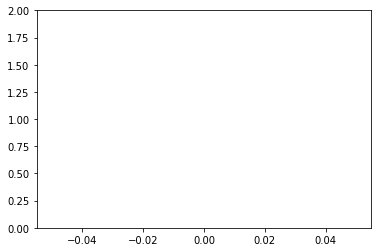

In [10]:
plt.plot(pd.Series(train_ppl.v('loss_history')).rolling(window=10).mean())
plt.ylim((0, 2))
plt.show()

## Validation

In [11]:
predict_template = (Pipeline()
     .add_namespace(np)
     .init_variable('metrics')
     .init_model('dynamic', UNet, 'model', config={
                    'device': 'gpu:3', 'load/path': 'unet/model.torch'
                })
     .predict_model('model', B('crops'), fetches=['proba', 'labels'],
                    save_to=[B('proba', mode='w'), B('labels', mode='w')])
#      .gather_metrics(SegmentationMetricsByPixels, targets=B('masks'), predictions=B('proba'),
#                     fmt='proba', axis=-2, save_to=V('metrics', mode='u'))
     .update(WS('pred'), B('labels'))
)

In [12]:
predict_ppl = (load_template
             + split_template
             + seg_template
             + predict_template
            ) << ds.test

NameError: name 'load_template' is not defined

In [18]:
def plot_prediction(segment):
    plt.figure(figsize=(5, 15))
    plt.subplot(131)
    plt.title('DL')
    plt.imshow(segment.core_dl / 255)
    plt.xticks([])

    plt.subplot(132)
    plt.title('Mask')
    plt.imshow(np.tile(np.expand_dims(segment.mask, axis=-1), (1, segment.core_dl.shape[-2])), vmin=0, vmax=3)
    plt.yticks([])
    plt.xticks([])

    plt.subplot(133)
    plt.title('Pred')
    plt.imshow(np.tile(segment.pred, (1, segment.core_dl.shape[-2])), vmin=0, vmax=3)
    plt.yticks([])
    plt.xticks([])

    plt.show()


 18%|█▊        | 2/11 [00:15<00:43,  4.86s/it]

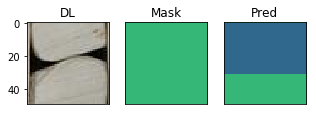

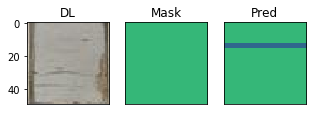

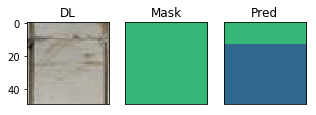

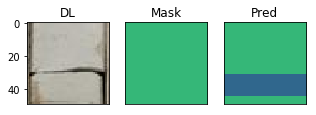

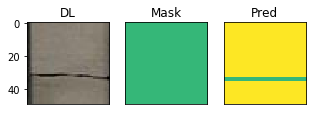

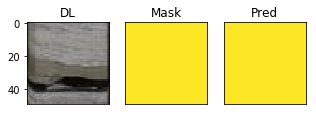

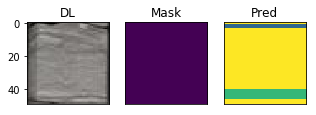

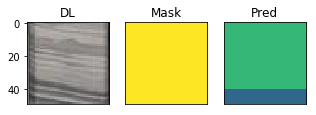

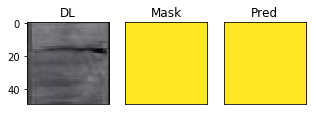

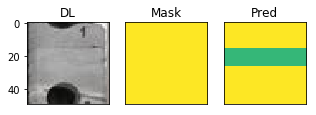

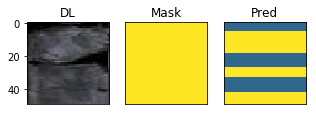

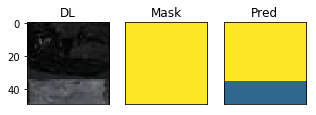

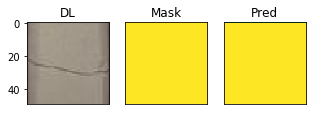

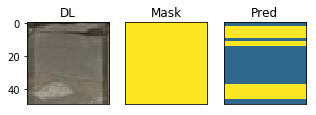

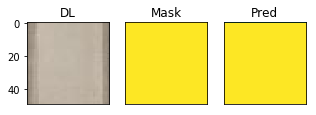

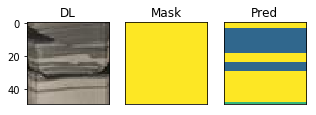

In [20]:
b = predict_ppl.next_batch(4, bar=True, n_epochs=1)

for segment in [segment for well in b.wells for segment in well.iter_level()]:
    plot_prediction(segment)